In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, RandomizedPCA
from sklearn.preprocessing import scale
from sklearn.manifold import Isomap, TSNE
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
def df_filter(df):
    ind = []
    for i in range(df.shape[0]):
        if all(df.iloc[i,:] != ' -nan'):
            ind.append(i)
    df = df.astype('float64')
    return(df.iloc[ind,:])

def feature_hist(df, ncol=4, len_single_plot = 5):
    n = df.shape[1]
    if((n % ncol)==0):
        nrow = n / ncol
    else:
        nrow = int(n / ncol) + 1
    fig, ax = plt.subplots(nrow, ncol, figsize=(len_single_plot*ncol, len_single_plot*nrow))
    ax = ax.reshape(-1,)
    for i in range(n):
        ax[i].hist(df.iloc[:,i], label = df.columns[i])
        ax[i].legend()
    return

In [11]:
# CLIQ funcfions. Put into a module in the future.

############################################################
# developed in Python 2.7.3 (tested on Python 3.5.0)       #
# by Chen Xu  cxu3@uncc.edu                                #
# Department of Bioinformatics and Genomics, UNC-Charlotte #       
# Aug 2014
# newest update Feb 2017                                                 #
############################################################

import re, os, sys, getopt
from collections import defaultdict
import itertools

### step4. format output 
### infile: one line for one clique
### outfile: cluster ID in a column; line Number is the cell index
def output(clique_list=None, outfile=None, number_cells=None):
	if (clique_list is None) or (outfile is None) or (number_cells is None): 
		sys.stderr.write("wrong argument number from output()")
		sys.exit(1)
	cell_clqID={}

	clqID=1
	for line in clique_list:
		cells=line.split(' ')
		cells=list(map(int, cells))  # index
		if len(cells)<3:
			for c in cells:
				cell_clqID[c]="-1"
		else:
			for c in cells:
				cell_clqID[c]=str(clqID)
			clqID+=1
	try:
		outfn=open(outfile, 'w')
		for c in range(1,number_cells+1):
			if c in cell_clqID:
				outfn.write(cell_clqID[c]+'\n')
			else:   # some cells have not been covered because no clique found for them.
				outfn.write('-1\n')
		outfn.close()
	except IOError:
		sys.stderr.write("cannot open outfile\n")
		sys.exit(1)
# end 4


### 3. delete overlap. After merging, if one cell appears in multiple cliques (and the cliques do not satisfy merging), select one cliq for the cell to be in. At the same time, delete the cell from the other cliques.
### criteria: select the cliq who has bigger average link weights to the node (by checking the SNN graph)
def uniq(clique_list=None, edgeFile=None, outfile=None):
	# clique_list: clique output from merge() 
	# edgeFile: pair of nodes and weigh of edge (3 column file)
	# outfile: clique output file, each line is a clique
	if (clique_list is None) or (edgeFile is None): 
		sys.stderr.write("wrong argument number from uniq()")
		sys.exit(1)

	# read in the edge file (node1\tnode2\tweight)
	A=defaultdict(dict)
	try:
		infn=open(edgeFile,'r')
		for line in infn:
			line=line.rstrip('\r\n')
			lst=line.split()
			A[lst[0]][lst[1]]=lst[2]
			A[lst[1]][lst[0]]=lst[2]
		infn.close()
	except IOError:
		sys.stderr.write("cannot open "+edgeFile+"\n")
		sys.exit(1)

	# parse the clique list
	cell_cliq=defaultdict(list)
	cliq_cell=defaultdict(list)
	cliqNum=1
	for line in clique_list:
		cells=line.split(' ')
		for c in cells:
			cell_cliq[c].append(str(cliqNum))
			cliq_cell[str(cliqNum)].append(c)
		cliqNum+=1

#------------------- unique assign---------------------------------------- 
	for c in list(cell_cliq.keys()): # for each node
		if len(cell_cliq[c])>1:  # if it is in more than one clique
			# count links in each clique associated with the cell
			count_link=defaultdict(list) # key: cliq, value: weighted link in the cliq to the node
			for connect_node in A[c].keys(): # each neighbor of node c
				for cl in cell_cliq[connect_node]: # for each clique that node c in
					if cl in cell_cliq[c]:
						count_link[cl].append(A[c][connect_node])
			# calculate the average of link weights connect from the cliq to the node c		
			max_link={}
			for cl in count_link.keys():
				max_link[cl]=sum(list(map(float,count_link[cl])))/len(count_link[cl])
			# select the clique to assign the node c
			assign_cliq=max(max_link, key=max_link.get)		
			#print c+" in "+" ".join(cell_cliq[c])+" assign: "+assign_cliq	
			
			# assign to one and delete in other cliqs
			for cl in cell_cliq[c]:
				if not cl==assign_cliq:
					cliq_cell[cl].remove(c)

#--------------- output------------------------------------------
	uniqCliq_list=[]
	for cl in sorted(list(map(int,cliq_cell.keys()))):
		if len(cliq_cell[str(cl)])>0:
			uniqCliq_list.append(" ".join(cliq_cell[str(cl)])+'\n')	

	if outfile:
		try:
			outfn=open(outfile,'w')
			outfn.write("\n".join(uniqCliq_list))
			outfn.close()
		except IOError:
			sys.stderr.write("cannot open "+outfile+"\n")	
			sys.exit(1)
	
	return uniqCliq_list

## end 3.


### step2. merge quasi-clique. Some cluster are long and extended. Need to merge quasi-cliques to find such cluster.
### be aware that after merging, the new clusters generated are bigger and have the potential to be merged again.
### cutoff: the shared must exceed the cutoff percent in one clique to be merged
def merge(clique_list=None, cutoff=None):
	# clique_list: clique output from findquasicliq(). one line is space deliminated indices of a cluster.
	# cutoff: threshold of overlapping rate for merging
	if (clique_list is None):
		sys.stderr.write("wrong argument number from merge()")
		sys.exit(1)
	if cutoff is None:	cutoff=0.5 # 
	cell_cliq=defaultdict(list) # key: cell ID, value: a list of cliq ID(str) that the cell belongs to
	cliq_cell=defaultdict(list) # key: cliq ID(str), value: a list of cells ID in the cliq
	cliqNum=1

	for line in clique_list:
		cells=line.split(' ')
		for c in cells:
			cell_cliq[c].append(str(cliqNum))
			cliq_cell[str(cliqNum)].append(c)
		cliqNum+=1

		
#------------- inner merge cycle---------------------------
	merged_bl=mergeOnline(cutoff, cell_cliq, cliq_cell)
	while merged_bl:
		#for cl in cliq_cell.keys():
		#	print str(cl)+" cliq: "+" ".join(cliq_cell[cl])
		#for c in cell_cliq.keys():
		#	print c+" cell: "+" ".join(list(map(str,cell_cliq[c])))
		#print "------ new merge begins ------"
		merged_bl=mergeOnline(cutoff, cell_cliq, cliq_cell)

#------------- output --------------------------------------
	mergedCliq_list=[]
	for cl in cliq_cell.keys():
		mergedCliq_list.append(" ".join(cliq_cell[cl]))
	return mergedCliq_list

# 2a. on-line merging algorithm. refresh the cliques and re-do the candidate searching after each merge happens. 
# sort the candidate of merging by the size of cliques, this will allow bigger clique join small cliques first, instead of small cliques join first.
def mergeOnline(cutoff=None, cell_cliq=None, cliq_cell=None):
	# the function will make one possible merge and return

	overlapCliq={} # pairs of cliques that have overlap in between
	# overlapCliq: key is pair of clique names, value is Number of cells overlapping between them
	for c in cell_cliq.keys():
		if len(cell_cliq[c])>1:
			if len(cell_cliq[c])>2: ## pair-wise if 1 cell appear in more than 2 cliques.
				s=list(itertools.combinations(cell_cliq[c],2))
				for pair in s:
					grp=" ".join(pair)
					if grp in overlapCliq:
						overlapCliq[grp]+=1
					else:
						overlapCliq[grp]=1
			else:
				grp=" ".join(cell_cliq[c])
				if grp in overlapCliq:
					overlapCliq[grp]+=1
				else:
					overlapCliq[grp]=1

	
	#select overlapped cliques to merge
	# Since one cliq can overlap with multiple cliqs, create a score to sort all possible mergings
	# score is the size of the cliques to merge
	cliq2Merge={}
	for grp in overlapCliq.keys():
		#print "overlap "+grp+": "+str(overlapCliq[grp])
		clqs=grp.split(' ')
		ol=overlapCliq[grp]
		bl=0 # boolean to see if it qualify a merge
		ss=0 # sum of score (sum of overlap proportion in each cliq of the group)
		sum_size=0
		for cl in clqs:
			sum_size+=len(cliq_cell[cl])
			# algo2: overlapping rate only need to exceed cutoff in one cliq
			score=float(ol)/len(cliq_cell[cl])
			ss+=score
			if score>=cutoff:
				bl=1
		if bl==1:
			cliq2Merge[grp]=sum_size
	
	# online merge: merge only one candidate group, then refresh.
	# merge the one with the biggest score
	currCliqNum=max(list(map(int, cliq_cell.keys())))+1
	if len(cliq2Merge.keys()):
		grp=max(cliq2Merge, key=cliq2Merge.get)	
		#print "merge "+grp+": "+str(cliq2Merge[grp])	
		new={}
		for cl in grp.split(' '):
			for c in cliq_cell[cl]:
				new[int(c)]=''
				# refresh the cell_cliq for on-line learning 
				index=cell_cliq[c].index(cl)
				del cell_cliq[c][index]   # delete old cliq index
				if str(currCliqNum) not in cell_cliq[c]: # add new cliq index
					cell_cliq[c].append(str(currCliqNum)) 
			del cliq_cell[cl]
		cliq_cell[str(currCliqNum)]=list(map(str,sorted(new.keys())))

	return len(cliq2Merge.keys())
		
# end of mergeInner
## end 2. merge()

### step 1. find quasi-clique
# find a r-quasi-clique associated with each node greedily
# inFile: pair-wise similarity #format: "node_index node_index edge_similarity\n"
# r: cutoff for quasi-clique
def findQuasiCliq(infile=None, r=None):
	if infile is None: 
		sys.stderr.write("wrong argument number for findQuasiCliq()")
		sys.exit(1)
	if r is None:	r=0.7 # 
	minCliqueSize=3 # minimum acceptable clique size

	nodehash=defaultdict(list)
	try:
		infn=open(infile,'r')
		for line in infn:
			line=line.rstrip('\r\n')
			lst=line.split()
			if len(lst)<3 or (not lst[0].isdigit()) or (not lst[1].isdigit()):
				sys.stderr.write("Error: input file not in the right format:\nIndex_of_node1 Index_of_node2 Weight_of_edge\n")
				sys.exit(1)
			try:
				float(lst[2])
			except ValueError:
				sys.stderr.write("Error: input file not in the right format:\nIndex_of_node1 Index_of_node2 Weight_of_edge\n")
				sys.exit(1)
			if float(lst[2])>0:
				nodehash[lst[0]].append(lst[1])
				nodehash[lst[1]].append(lst[0])
		infn.close()
	except IOError:
		sys.stderr.write("Error: cannot open input file "+infile+"\n")	
		sys.exit(1)

#-----------------find clique for each node -------------------
	cliques={}
	
	for node in sorted(nodehash): 
		neighList=list(nodehash[node]) ### get all neighbors
		while 1:
			if len(neighList)<(minCliqueSize-1):
				break
			degreeHash={} ### each neighbor connect to how many of the other neighbors
			for neighNode in neighList:
				neighNeighList=list(nodehash[neighNode])
				degree=len(set(neighNeighList) & set(neighList))+1
				degreeHash[neighNode]=degree

			### greedy: start from the neighbor with the least connection to other neighbors
			minDegNeigh=min(degreeHash, key=degreeHash.get)
            ## %NeighHash length is the number of all neighbors to the Node (including the minDegNeigh itself
			if degreeHash[minDegNeigh]>=int(len(neighList)*r+1):
				###  the local cluster satisfy to be a quasi-clique
				break
			else:
				### does not satisfy, delete the neighbor
				neighList.remove(minDegNeigh)
			
		# quasi-cliq found	
		if len(neighList)>=(minCliqueSize-1):	
			neighList.append(node)
			neighList.sort(key=int)
			cliques[" ".join(neighList)]=len(neighList)

	#for clq in cliques.keys():
	#	print clq

#------------------ delete redundant clique -----------------------
### delete cliques that are part of other cliques
	cliques_clean={}
	for currCliq in sorted(cliques, key=cliques.get, reverse=True):
		bl=1 # bl=1: unique ; bl=0: redundant
		for existCliq in sorted(cliques_clean, key=cliques_clean.get, reverse=True):
			if (cliques_clean[existCliq] <= cliques[currCliq]):
				break
			else:
				bl=0
				currCliqAry=currCliq.split(" ")
				existCliqAry=existCliq.split(" ")
				for win in currCliqAry:
					if win not in existCliqAry:
						bl=1  # unique
						break
				if bl==0:
					break
		if bl:
			cliques_clean[currCliq]=cliques[currCliq]

	max_ID=max(list(map(int, nodehash.keys())))
	return (cliques_clean.keys(),max_ID)
# end 1.
################       end of algorithm         #########


1. SNN step...
Create KNN matrix...
Time elapsed:	 0.012707315036095679
Generate edges...
Time elapsed:	 2.4190892910119146
# edges:	 14850
   node1  node2  weight
0      1      2    46.0
1      1      3    46.0
2      1      4    31.0
3      1      5    48.5
4      1      6    29.5
2. Cliq Step...
input file snn_edge.txt
find 3 quasi-cliques
merged into 3 clusters
unique assign done
Time elapsed:	 0.3268734799930826


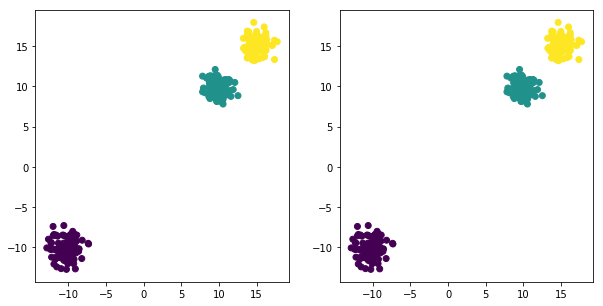

In [54]:
from sklearn.neighbors import NearestNeighbors
from timeit import default_timer as timer

def match1d(query, target):
    query = query.tolist()
    target = target.tolist()
    target = dict(zip(target, range(len(target))))
    if(set(query).issubset(set(target.keys()))):
        result = [target[i] for i in query]
        return(np.array(result))
    else:
        print("Query should be a subset of target!")
        return
    
def SNN(x, k=3):
    '''
    x: n x m matrix, n is #sample, m is #feature
    '''
    n, m = x.shape
    # Find a ranklist of neighbors for each sample
    timestamp = timer()
    print('Create KNN matrix...')
    knn = NearestNeighbors(n_neighbors=n)
    knn.fit(x)
    A = knn.kneighbors_graph(x, mode='distance')
    A = A.toarray()
    A_rank = A
    for i in range(n):
        A_rank[i,:] = np.argsort(A[i,:])
    A_rank = np.array(A_rank, dtype='int')
    A_knn = A_rank[:,:k]
    print("Time elapsed:\t", timer() - timestamp)

    # Create weighted edges between samples
    timestamp = timer()
    print('Generate edges...')
    edge = []
    for i in range(n):
        for j in range(i+1,n):
            shared = set(A_knn[i,:]).intersection(set(A_knn[j,:]))
            shared = np.array(list(shared))    
            if(len(shared) > 0): # When i and j have shared knn
                strength = k - (match1d(shared, A_knn[i,:]) + match1d(shared, A_knn[j, :]) + 2)/2
                strength = max(strength)
                if(strength>0):
                    edge = edge + [i+1, j+1, strength]            
    edge = np.array(edge).reshape(-1, 3)
    print("Time elapsed:\t", timer() - timestamp)
    return(edge)

def SNN_cliq(x, k_nn=10, merge_cutoff=0.5, r_cutoff=0.7):
    
    print('1. SNN step...')
    edge = pd.DataFrame(SNN(x, k_nn), 
                        columns=['node1', 'node2', 'weight']
                        )
    edge = edge.astype(dtype={'node1':'int', 'node2':'int', 'weight':'float'})
    print('# edges:\t', edge.shape[0])
    print(edge.head())
    edge_file = 'snn_edge.txt'
    pd.DataFrame(edge).to_csv(edge_file, sep='\t', index=False, header=False)
    
    print('2. Cliq Step...')
    timestamp = timer()
    cliques=[]
    results=findQuasiCliq(edge_file, r_cutoff)
    cliques=results[0]
    max_ID=results[1]
    number_cells = x.shape[0]
    print("input file "+edge_file)
    print("find "+str(len(cliques))+" quasi-cliques")
    
    merge_cliques=[]
    merge_cliques=merge(cliques, merge_cutoff)
    print("merged into "+str(len(merge_cliques))+" clusters")
    uniq_cliques=[]
    uniq_cliques=uniq(merge_cliques, edge_file)
    
    outfile = 'cliq.txt'
    print("unique assign done")
    output(uniq_cliques, outfile, number_cells)
    
    prediction = np.loadtxt(outfile)
    print("Time elapsed:\t", timer()-timestamp)
    return(prediction)

'''
# Testing example
'''
fig, ax = plt.subplots(1,2,figsize=(10,5))

x1 = np.random.randn(100,2)-10
x2 = np.random.randn(100,2)+10
x3 = np.random.randn(100,2)+15

X = np.append(x1, x2, axis=0)
X = np.append(X, x3, axis=0)
y = [0]*len(x1)+[1]*len(x2)+[2]*len(x3)
ax[0].scatter(X[:,0], X[:,1], c=y)

y_pred = SNN_cliq(X, 50)
ax[1].scatter(X[:,0], X[:,1], c=y_pred)

In [3]:
df = pd.read_csv('swc_files_preprocessed/features.csv', index_col=[0])
df = df_filter(df)

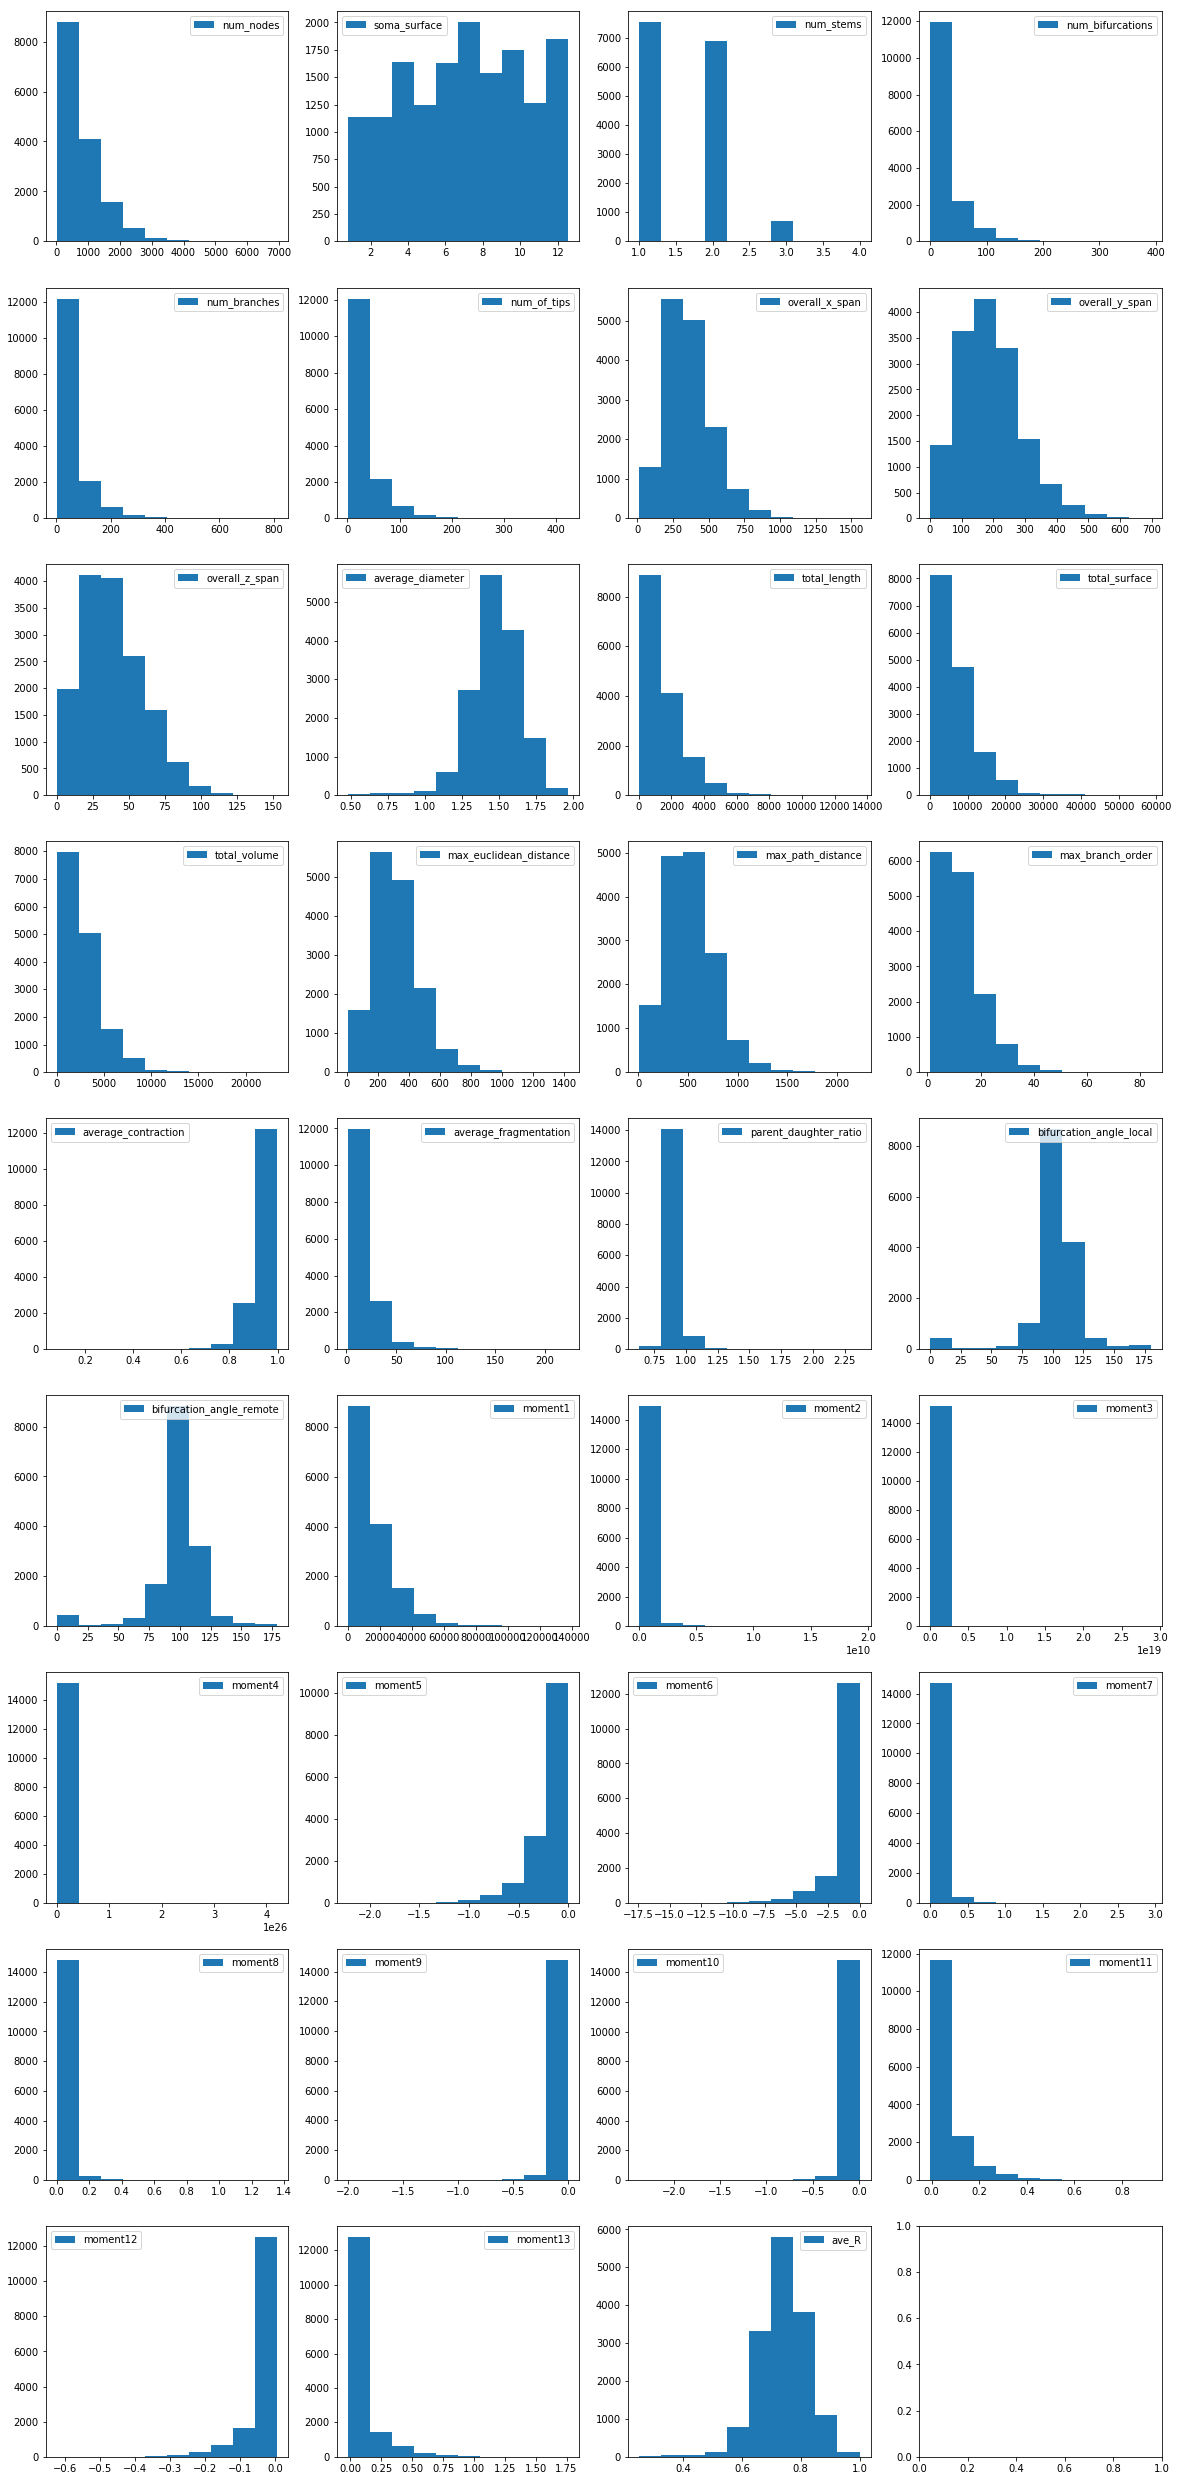

In [4]:
feature_hist(df)

In [5]:
# Step1: Load data
feature_morph = df.iloc[:, :21]
feature_morph_scale = pd.DataFrame(scale(feature_morph), index=feature_morph.index, columns=feature_morph.columns)
feature_gmi = df.iloc[:,21:]
feature_gmi = feature_gmi / np.max(feature_gmi, axis=0)
feature_gmi_scale = pd.DataFrame(scale(feature_gmi), index=feature_gmi.index, columns=feature_gmi.columns)

# # Remove outliers
# feature_morph_scale = feature_morph_scale.iloc[:, scipy.stats.kurtosistest(feature_morph_scale, axis=0).pvalue>10**(-5)]
# print(feature_morph_scale.shape, feature_morph_scale.columns.tolist())
# feature_gmi_scale = feature_gmi_scale.iloc[:, scipy.stats.kurtosistest(feature_gmi_scale, axis=0).pvalue>10**(-5)]
# print(feature_gmi_scale.shape, feature_gmi_scale.columns.tolist())

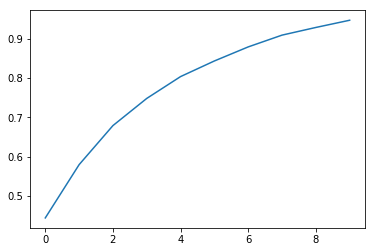

In [6]:
# Create a regular PCA model 
pca = PCA(n_components=10)
# pca = RandomizedPCA(n_components=2)

# Fit and transform the data to the model
reduced_data_pca = pca.fit_transform(feature_morph_scale)

tp = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(0, len(tp)), tp)

Running Isomap...
Running tSNE...


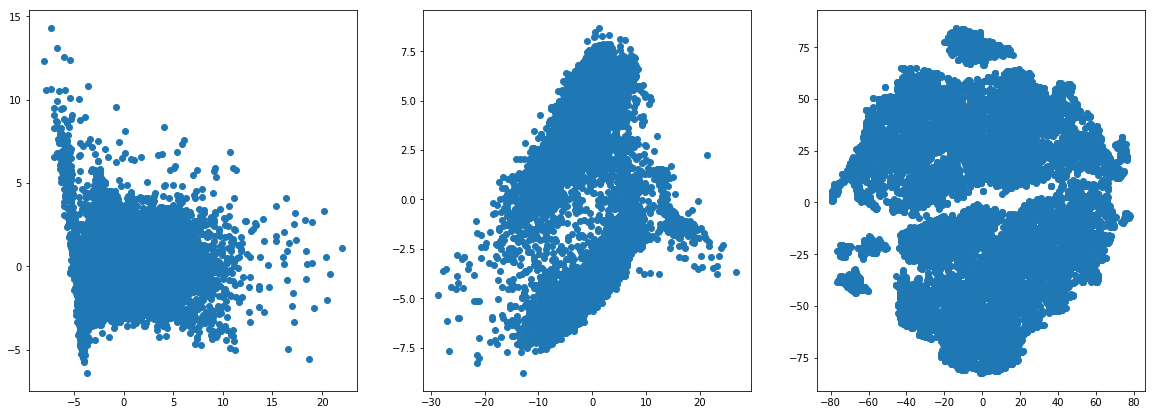

In [7]:
fig, ax = plt.subplots(1,3, figsize=(20, 7))

# PCA
ax[0].scatter(reduced_data_pca[:, 0], reduced_data_pca[:, 1])

# Isomap
print('Running Isomap...')
isomap = Isomap(n_neighbors=10)
X_iso = isomap.fit_transform(reduced_data_pca)
ax[1].scatter(X_iso[:, 0], X_iso[:, 1])

# tSNE
print('Running tSNE...')
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(reduced_data_pca)
ax[2].scatter(X_tsne[:, 0], X_tsne[:, 1])

## Clustering 

In [ ]:
lab = np.random.choice(np.arange(len(reduced_data_pca)), 5000, replace=False)
y_pred = SNN_cliq(reduced_data_pca[lab, :], 50)
plt.scatter(X_tsne[lab,0], X_tsne[lab,1], c=y_pred, cmap='tab20')

1. SNN step...
Create KNN matrix...
Time elapsed:	 3.3902804689714685
Generate edges...
Time elapsed:	 28138.895702948095
# edges:	 1383566
   node1  node2  weight
0      1     17    43.0
1      1     42    13.5
2      1     51    33.0
3      1     69    28.0
4      1     80    26.0
2. Cliq Step...


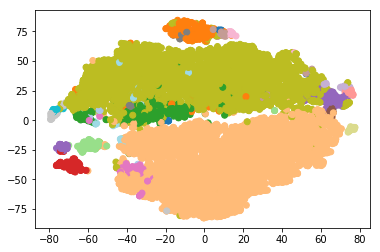

In [61]:
plt.scatter(X_tsne[lab,0], X_tsne[lab,1], c=y_pred, cmap='tab20')

In [49]:
y_pred = SNN_cliq(reduced_data_pca, 20)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_pred)

1. SNN step...
Create KNN matrix...
Time elapsed:	 32.63513057702221
Generate edges...


KeyboardInterrupt: 

In [47]:
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, Birch


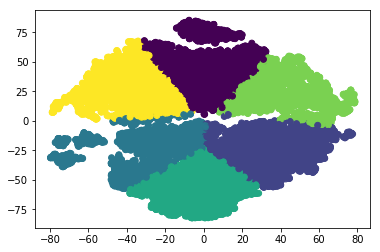

In [25]:
y_pred = KMeans(n_clusters=6, random_state=46).fit_predict(X_tsne)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred)

DescribeResult(nobs=15188, minmax=(0, 0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)


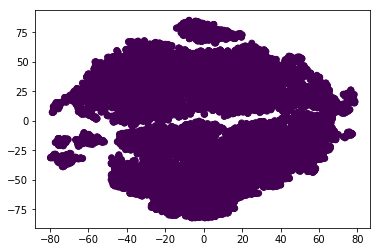

In [48]:
y_pred = DBSCAN(eps=20, min_samples=100).fit_predict(X_tsne)
print(scipy.stats.describe(y_pred))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred)

DescribeResult(nobs=15188, minmax=(0, 2), mean=0.8524493020805899, variance=0.6749416531219201, skewness=0.27848937497364745, kurtosis=-1.4650129095715219)


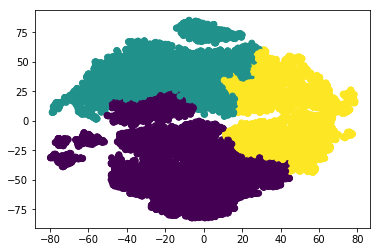

In [49]:
y_pred = Birch().fit_predict(X_tsne)
print(scipy.stats.describe(y_pred))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred)